In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.expand_frame_repr', False) 
tickers = ['MASI', 'MSI20', 'ESG10']

year_start = '2021'
year_end   = '2023'

In [29]:
def extract_data(file_path):
    return pd.read_excel(file_path)

folder = 'indices/D' + year_start + '_' + year_end + '/'
ext = '.xls'

folderIMG = 'results/plots/'
png = '.png'

In [30]:
close_df = pd.DataFrame()

for ticker in tickers:
    file = folder + ticker + ext
    data = extract_data(file)
    data = data.set_index('Date')

    close_df[ticker] = data['Dernier']

log_returns = close_df.pct_change()    
log_returns = log_returns.dropna()

In [31]:
portfolio_value = 1_000_000
log_returns

,MASI,MSI20,ESG10
Date,,,
28 déc. 2023,-0.003826,-0.003897,-0.007940
27 déc. 2023,0.004761,0.006452,0.005247
26 déc. 2023,-0.001541,-0.002262,-0.002311
25 déc. 2023,0.005120,0.005791,0.005812
22 déc. 2023,0.002874,0.003003,0.001515
...,...,...,...
8 janv. 2021,-0.004235,-0.004649,-0.004575
7 janv. 2021,0.001963,0.002090,0.005207
6 janv. 2021,-0.004926,-0.006349,-0.008775


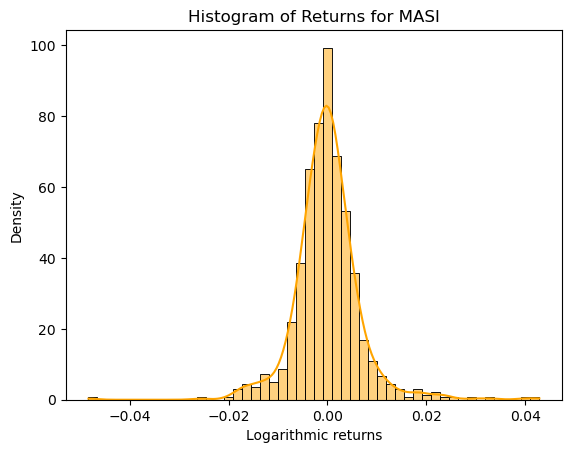

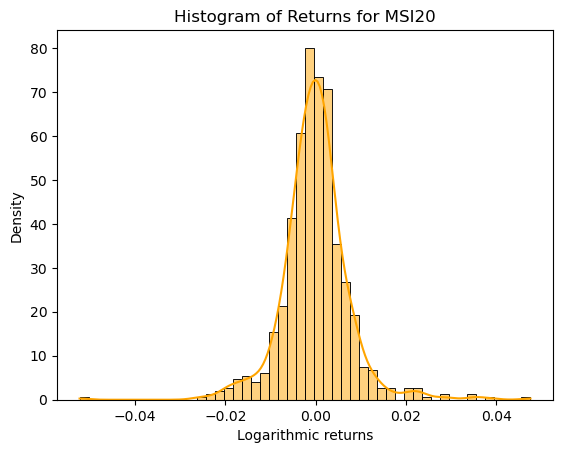

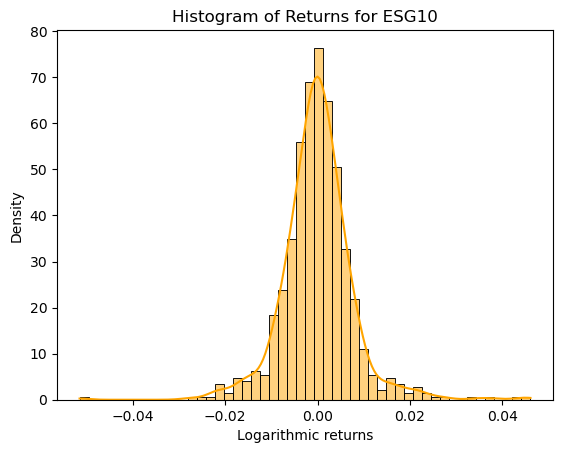

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


# Supposons que log_returns[ticker] contient vos données de rendements logarithmiques
for ticker in tickers:
    # Créer l'histogramme avec seaborn
    filtered_returns = log_returns[ticker][log_returns[ticker] != 0]
    sns.histplot(filtered_returns, bins=50, kde=True, color='orange', stat='density')

    # Ajouter des étiquettes et un titre
    plt.xlabel('Logarithmic returns')
    plt.ylabel('Density')
    plt.title(f'Histogram of Returns for {ticker}')

    # Afficher le graphique
    plt.savefig(folderIMG+'density_'+ticker+png)
    plt.show()


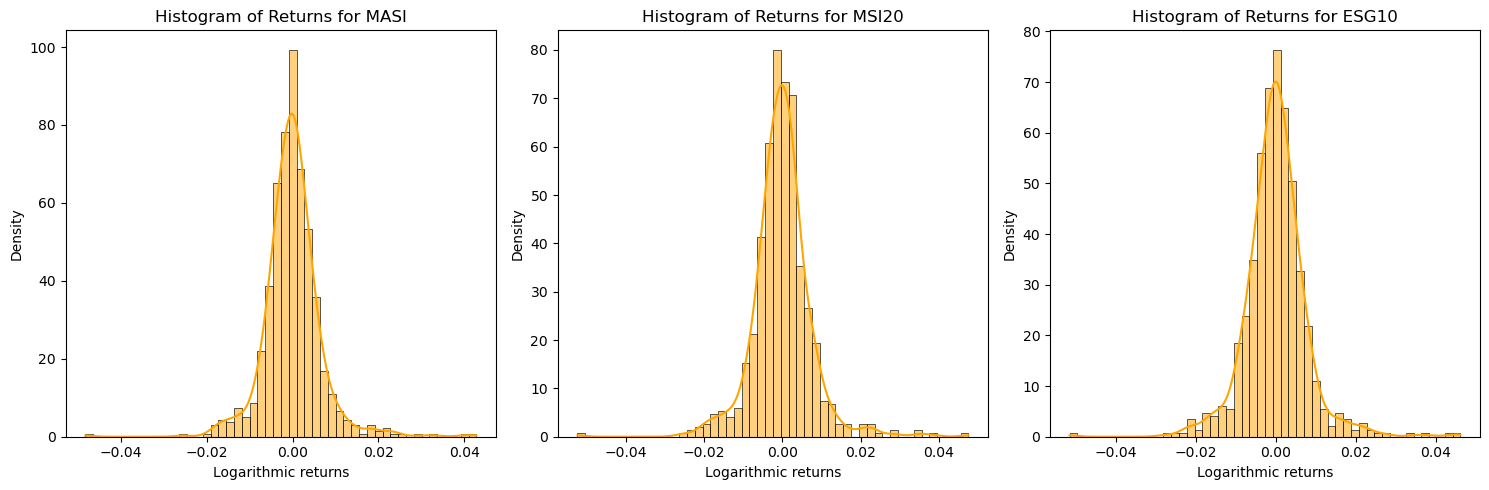

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Supposons que log_returns[ticker] contient vos données de rendements logarithmiques
for idx, ticker in enumerate(tickers):
    # Créer l'histogramme avec seaborn
    filtered_returns = log_returns[ticker][log_returns[ticker] != 0]
    sns.histplot(filtered_returns, bins=50, kde=True, color='orange', stat='density', ax=axs[idx])

    # Ajouter des étiquettes et un titre
    axs[idx].set_xlabel('Logarithmic returns')
    axs[idx].set_ylabel('Density')
    axs[idx].set_title(f'Histogram of Returns for {ticker}')

plt.tight_layout()
plt.savefig(folderIMG+'density_'+'ALL'+png)
plt.show()

## Statistics of our samples

In [34]:
from scipy.stats import skew, kurtosis, jarque_bera

statistics = pd.DataFrame(
    index=[
        'Size',
        'Mean',
        'Standard deviation',
        'Skewness',
        'Excess Kurtosis',
        'Jarque-Bera'
    ]
)

for ticker in tickers:
    filtered_returns = log_returns[ticker][log_returns[ticker] != 0]
    statistics[ticker] = [
            len(filtered_returns),
            np.mean(filtered_returns),
            np.std(filtered_returns),
            skew(filtered_returns),
            kurtosis(filtered_returns, fisher=False),
            jarque_bera(filtered_returns)[0]
        ]


# saving in csv file
statistics.to_csv('results/csv/statistics.csv') 

# Output the statistics
statistics

,MASI,MSI20,ESG10
Size,751.000000,751.000000,751.000000
Mean,-0.000063,-0.000056,-0.000024
Standard deviation,0.006731,0.007550,0.007735
Skewness,0.513636,0.403603,0.390894
Excess Kurtosis,12.072876,10.823608,10.196225
Jarque-Bera,2608.860430,1935.715596,1639.584707


## VaRs Calculs

In [35]:
basic = pd.DataFrame(
    index=[
        'Size',
        'Mean',
        'Standard deviation',
        'Skewness',
        'Excess Kurtosis',
        'Jarque-Bera'
    ]
)

for ticker in tickers:
    filtered_returns = close_df[ticker][close_df[ticker] != 0]
    basic[ticker] = [
            len(filtered_returns),
            np.mean(filtered_returns),
            np.std(filtered_returns),
            skew(filtered_returns),
            kurtosis(filtered_returns, fisher=False),
            jarque_bera(filtered_returns)[0]
        ]
    
basic

,MASI,MSI20,ESG10
Size,752.000000,752.000000,752.000000
Mean,11964.689305,970.695533,898.534020
Standard deviation,926.595381,79.004715,67.955232
Skewness,0.008143,-0.093037,0.040158
Excess Kurtosis,2.355570,2.385388,2.350265
Jarque-Bera,13.020729,12.920991,13.429642


In [36]:
from scipy.optimize import curve_fit

# Fonction de modèle (fonction linéaire)
def linear_model(x, b0, b1):
    return b0 + b1 * x

def gamma(k,x):
    N = len(x)
    som = 0
    for j in range(1,k):
        som += np.log(x[N-j])-np.log(x[N-k-1])
    results = som / k
    return results

deg_freedom = pd.DataFrame(index=['Degrees of Freedom'])
for ticker in tickers:
    filtered_returns = log_returns[ticker][log_returns[ticker] != 0]
    rt = filtered_returns.apply(abs).sort_values()

    # Données pour ajustement 
    N = len(rt)
    k_values = np.linspace(1,N//2,N//2).astype(int)  
    gamma_values = [gamma(k,rt) for k in k_values]  

    # Ajustement du modèle
    params, covariance = curve_fit(linear_model, k_values, gamma_values)

    # Récupération des paramètres ajustés
    b0_optimal, b1_optimal = params

    deg_freedom[ticker]= 1/b0_optimal
    #deg_freedom = (1/b0_optimal).astype(int) + 1

# saving in csv file
deg_freedom.to_csv('results/csv/degrees_of_freedom.csv')

deg_freedom

,MASI,MSI20,ESG10
Degrees of Freedom,2.90255,3.093503,3.113557


In [37]:
from scipy.stats import norm,t

    

confidence_levels = [0.950, 0.975, 0.980, 0.985, 0.990, 0.995, 0.999]
#confidence_levels = np.linspace(0.95, 0.99, 1000)

var_ntx = ['var-n','var-t','var-x']
col = ['r','b','y']

tableau_var = pd.DataFrame(index=confidence_levels)

for ticker in tickers:
    std = statistics.loc['Standard deviation', ticker]
    mu = statistics.loc['Mean', ticker]
    rt = log_returns[ticker][log_returns[ticker] != 0]
    
    # calcul var_n
    var_n = [ - std * norm.ppf(1-cl) for cl in confidence_levels]
    
    # calcul var_t
    k = np.mean(((rt - mu) / std) ** 2)
    beta = std ** 2 * (k + 3) / (2 * k + 3)
    n = 6 / k + 4
    var_t = [- np.sqrt(beta) * t.ppf(1-cl, n) for cl in confidence_levels]
    
    # calcul var_x
    df = deg_freedom[ticker]['Degrees of Freedom']
    calcul = std / (np.sqrt(df / (df-2)))
    var_x = [- t.ppf(1-cl, df)*calcul for cl in confidence_levels]
    
    # pushing in tab var
    tableau_var[ticker+' var-n'] = var_n
    tableau_var[ticker+' var-t'] = var_t
    tableau_var[ticker+' var-x'] = var_x    

In [38]:
# saving in csv file
tableau_var.to_csv('results/csv/var.csv')

# Output the Value at Risks
print('----------------------------Value At Risks----------------------------\n')
tableau_var

----------------------------Value At Risks----------------------------



,MASI var-n,MASI var-t,MASI var-x,MSI20 var-n,MSI20 var-t,MSI20 var-x,ESG10 var-n,ESG10 var-t,ESG10 var-x
0.950,0.011072,0.010912,0.008956,0.012418,0.012239,0.010435,0.012723,0.012539,0.010726
0.975,0.013193,0.013415,0.012176,0.014798,0.015046,0.014044,0.015160,0.015415,0.014422
0.980,0.013825,0.014205,0.013346,0.015506,0.015932,0.015340,0.015886,0.016323,0.015748
0.985,0.014608,0.015217,0.014970,0.016384,0.017068,0.017127,0.016786,0.017486,0.017575
0.990,0.015659,0.016640,0.017510,0.017564,0.018663,0.019898,0.017994,0.019121,0.020404
0.995,0.017339,0.019081,0.022670,0.019447,0.021402,0.025448,0.019924,0.021927,0.026065
0.999,0.020801,0.024948,0.040293,0.023331,0.027982,0.043864,0.023903,0.028668,0.044794


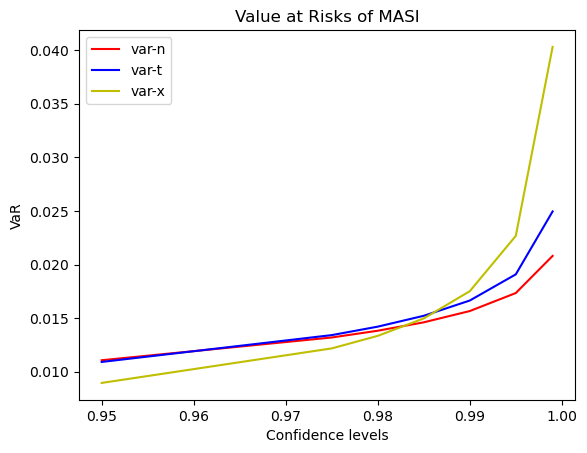

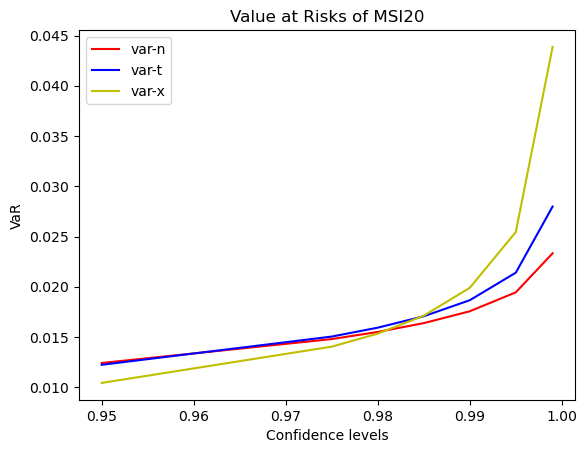

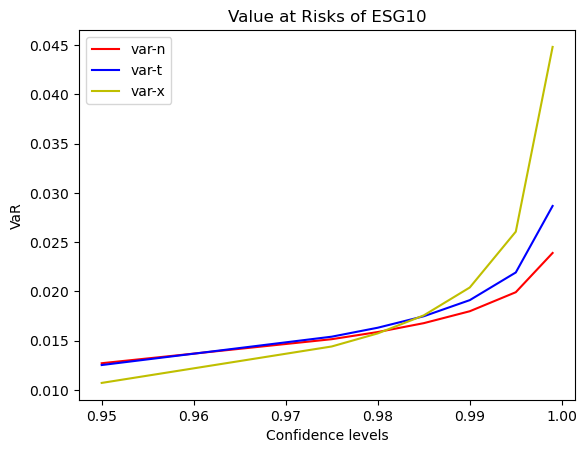

In [39]:
for ticker in tickers :
    for v,c in zip(var_ntx,col) :
        plt.plot(tableau_var[ticker+' '+v],color=c,label=v)
    plt.xlabel('Confidence levels')
    plt.ylabel('VaR')
    plt.title(f'Value at Risks of {ticker}')
    plt.legend()
    plt.savefig(folderIMG+'var_'+ticker+png)
    plt.show()

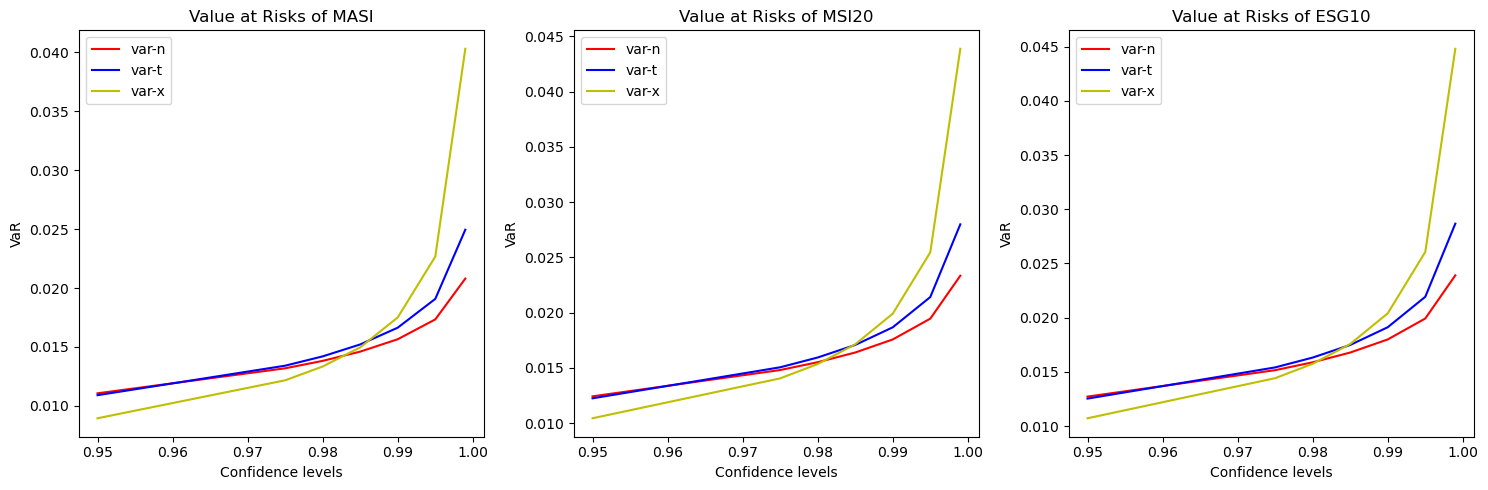

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for idx, ticker in enumerate(tickers):
    for v, c in zip(var_ntx, col):
        axs[idx].plot(tableau_var[ticker+' '+v], color=c, label=v)
        axs[idx].set_xlabel('Confidence levels')
        axs[idx].set_ylabel('VaR')
        axs[idx].set_title(f'Value at Risks of {ticker}')
        axs[idx].legend()

plt.tight_layout()
plt.savefig(folderIMG+'var_'+'ALL'+png)
plt.show()

In [41]:
tab = pd.DataFrame(index=confidence_levels)

for ticker in tickers :
    for v in var_ntx :
        l = []
        for cl in confidence_levels :
            filtered_returns = log_returns[ticker][log_returns[ticker] != 0]
            var = tableau_var[ticker+' '+v][cl]
            tab_ec = [x for x in filtered_returns if x < 0 and abs(x) > var]
            l.append(len(tab_ec) / len(filtered_returns))
        tab[ticker+' '+v] = l

print('----------------------------Failure Rates----------------------------\n')
tab.T

----------------------------Failure Rates----------------------------



,0.950,0.975,0.980,0.985,0.990,0.995,0.999
MASI var-n,0.038615,0.026631,0.023968,0.021305,0.017310,0.009321,0.002663
MASI var-t,0.039947,0.025300,0.023968,0.017310,0.014647,0.003995,0.002663
MASI var-x,0.055925,0.034621,0.026631,0.019973,0.009321,0.002663,0.001332
MSI20 var-n,0.041278,0.030626,0.025300,0.023968,0.017310,0.009321,0.003995
MSI20 var-t,0.043941,0.027963,0.023968,0.019973,0.014647,0.005326,0.001332
MSI20 var-x,0.054594,0.034621,0.026631,0.019973,0.009321,0.002663,0.001332
ESG10 var-n,0.042610,0.029294,0.025300,0.018642,0.014647,0.013316,0.003995
ESG10 var-t,0.043941,0.027963,0.023968,0.017310,0.013316,0.005326,0.001332
ESG10 var-x,0.053262,0.031957,0.027963,0.015979,0.011984,0.002663,0.001332


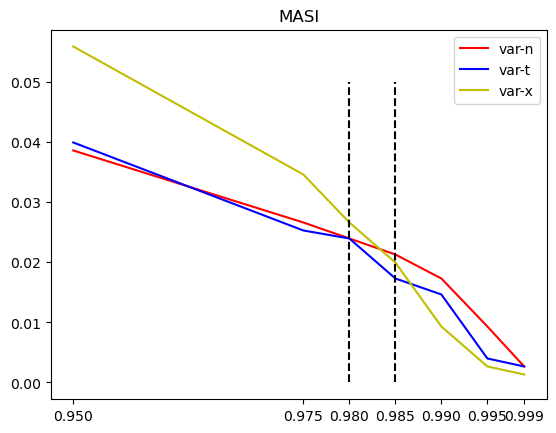

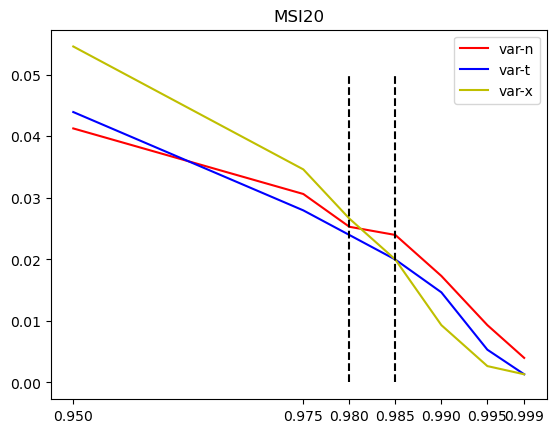

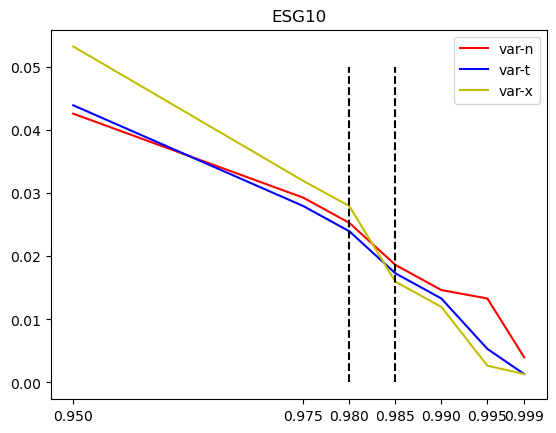

In [42]:
for ticker in tickers :
    for v,c in zip(var_ntx,col) :
        plt.plot(tab[ticker+' '+v],color=c,label=v)

#plt.plot(tab['MASI var-t'],color='b')

    # Repere norme
    y = np.ones(len(confidence_levels))
    y = y - confidence_levels
    # plt.plot(confidence_levels,y,color='g')
    # Recherche de x_change l'intersection entre var-n et var-x
    x_change = 0
    for i in range(len(confidence_levels)):
        if tab[ticker+' var-n'][confidence_levels[i]] > tab[ticker+' var-x'][confidence_levels[i]]:
            x_change = confidence_levels[i-1]
            x_change2 = confidence_levels[i]
            break

    # plot d'une bar en tiré de x
    plt.plot([x_change,x_change],[0,0.05],color='black',linestyle='dashed')
    plt.plot([x_change2,x_change2],[0,0.05],color='black',linestyle='dashed')

    plt.xticks(confidence_levels)
    plt.title(ticker)
    plt.legend()
    plt.savefig(folderIMG+'fr_'+ticker+png)
    plt.show()

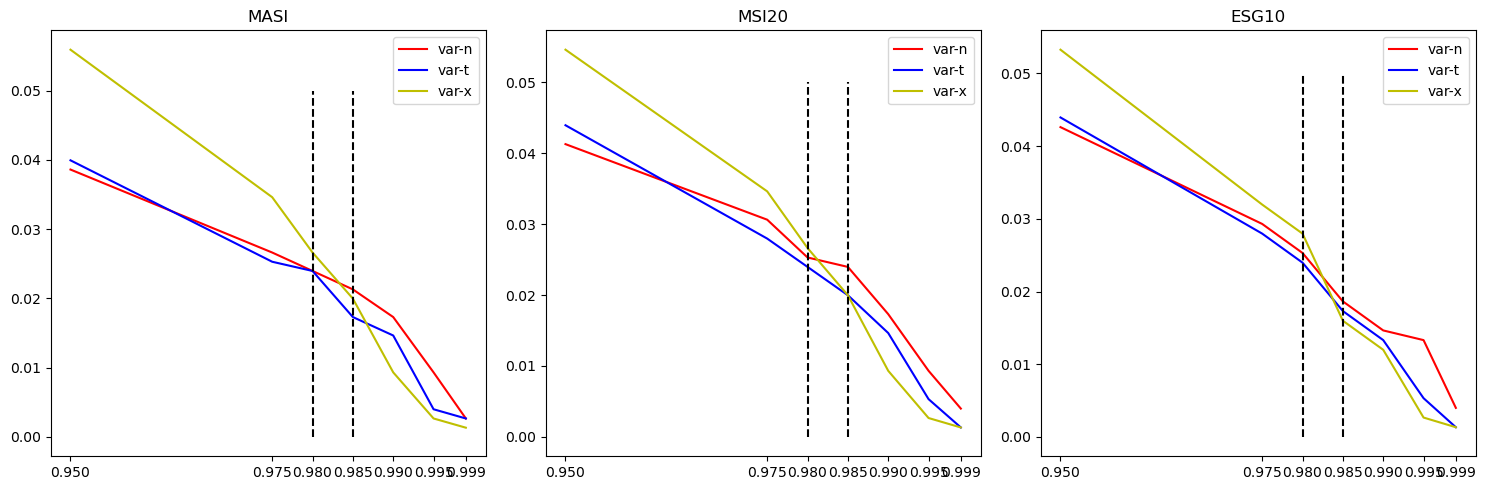

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for idx, ticker in enumerate(tickers):
    for v, c in zip(var_ntx, col):
        axs[idx].plot(tab[ticker+' '+v], color=c, label=v)

    x_change = 0
    for i in range(len(confidence_levels)):
        if tab[ticker+' var-n'][confidence_levels[i]] > tab[ticker+' var-x'][confidence_levels[i]]:
            x_change = confidence_levels[i-1]
            x_change2 = confidence_levels[i]
            break

    axs[idx].plot([x_change, x_change], [0, 0.05], color='black', linestyle='dashed')
    axs[idx].plot([x_change2, x_change2], [0, 0.05], color='black', linestyle='dashed')

    axs[idx].set_xticks(confidence_levels)
    axs[idx].set_title(ticker)
    axs[idx].legend()

plt.tight_layout()
plt.savefig(folderIMG+'fr_'+'ALL'+png)
plt.show()